# 이미지 분류 - 기본 (TF2)

https://www.tensorflow.org/tutorials/keras/classification?hl=ko


In [1]:
# 경고 메시지 출력 끄기
import warnings 
warnings.filterwarnings(action='ignore')

# 노트북 셀 표시를 브라우저 전체 폭 사용하기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
import matplotlib.pyplot as plt

import sys

rseed = 22
import random
random.seed(rseed)

import numpy as np
np.random.seed(rseed)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind': "{:.5f}".format})

import pandas as pd
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.5f}'.format

import tensorflow as tf
tf.random.set_seed(rseed)
tf.keras.backend.set_floatx('float32') # keras default float type 설정

print(f"python ver={sys.version}")
print(f"pandas ver={pd.__version__}")
print(f"numpy ver={np.__version__}")
print(f"tensorflow ver={tf.__version__}")

python ver=3.7.6 (default, Nov 21 2020, 22:51:13) 
[Clang 12.0.0 (clang-1200.0.32.27)]
pandas ver=1.0.5
numpy ver=1.19.5
tensorflow ver=2.4.1


## Fashion MNIST

Fashion MNIST는 10개의 Category와 70,000개의 28x28 흑백 이미지로 구성되어 있습니다.

![](https://tensorflow.org/images/fashion-mnist-sprite.png?hl=ko)

### 데이터 전처리

images shape: train=(60000, 28, 28), type=uint8
labels shape: (60000,), type=uint8


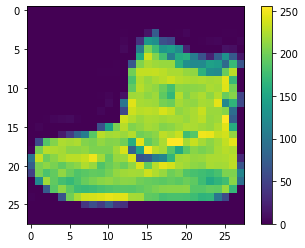

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"images shape: train={train_images.shape}, type={train_images.dtype}")
print(f"labels shape: {train_labels.shape}, type={train_labels.dtype}")

# 학습할 이미지는 28x28 사이즈의 0~255 사이 값을 가지는 패션 이미지 입니다.
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [3]:
# 학습에 용이하도록 0~1 사이 값을 가지는 float 형 값으로 변경합니다.
train_images = train_images / 255.0
test_images = test_images / 255.0
print(f"images shape: train={train_images.shape}, type={train_images.dtype}")

images shape: train=(60000, 28, 28), type=float64


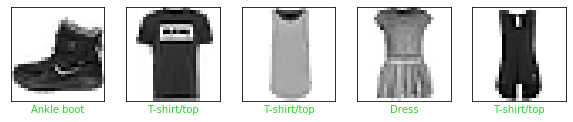

In [4]:
# 학습 데이터 샘플 출력
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]], color="limegreen")
plt.show()

### 모델 구성

***층 설정***

신경망의 기본 구성 요소는 층(layer)입니다. 층은 주입된 데이터에서 표현을 추출합니다. 아마도 문제를 해결하는데 더 의미있는 표현이 추출될 것입니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

이 네트워크의 첫 번째 층인 tf.keras.layers.Flatten은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 합니다.

픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


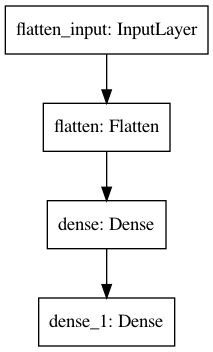

In [5]:
# Sequential 방식으로 모델 설계
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 모델 출력
model.summary()
tf.keras.utils.plot_model(model,to_file="/tmp/model.png")

### 모델 컴파일

* 손실 함수(Loss function): 훈련 하는 동안 모델의 오차 
* 옵티마이저(Optimizer): 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정
* 지표(Metrics): 훈련 단계와 테스트 단계를 모니터링

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy 손실 함수를 사용하면 학습/평가시 y 값을 one hot 인코딩 해주지 않아도 되어 편리
              metrics=['accuracy'])

### 모델 학습 및 평가

테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문입니다. 

과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

In [7]:
model.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 2s 715us/step - loss: 0.6386 - accuracy: 0.7757
Epoch 2/5
1875/1875 [==============================] - 1s 684us/step - loss: 0.3906 - accuracy: 0.8569
Epoch 3/5
1875/1875 [==============================] - 1s 695us/step - loss: 0.3387 - accuracy: 0.8760
Epoch 4/5
1875/1875 [==============================] - 1s 681us/step - loss: 0.3154 - accuracy: 0.8848
Epoch 5/5
1875/1875 [==============================] - 1s 681us/step - loss: 0.2940 - accuracy: 0.8912
313/313 - 0s - loss: 0.3457 - accuracy: 0.8771

테스트 정확도: 0.8770999908447266


### 예측

학습된 모델을 통해 예측을 해봅니다. 예측 결과는 각 클래스의 확률 값으로 출력됩니다. 

In [8]:
predictions = model.predict(test_images)
print(f"pred prob: {predictions[0]}")
print(f"pred class: {np.argmax(predictions[0])}")
print(f"real class: {test_labels[0]}")

pred prob: [0.00001 0.00000 0.00000 0.00000 0.00000 0.00319 0.00000 0.01791 0.00016
 0.97873]
pred class: 9
real class: 9


In [9]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'limegreen'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

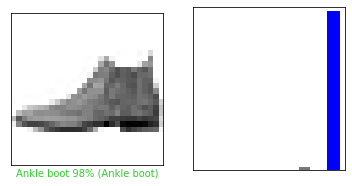

In [10]:
# 0번째 테스트 이미지에 대하여 예측을 하고 비교해봅니다.
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

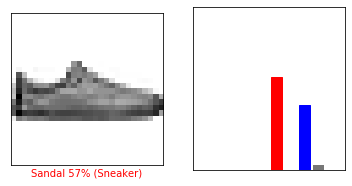

In [11]:
# 12번째 테스트 이미지에 대하여 예측을 하고 비교해봅니다.
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

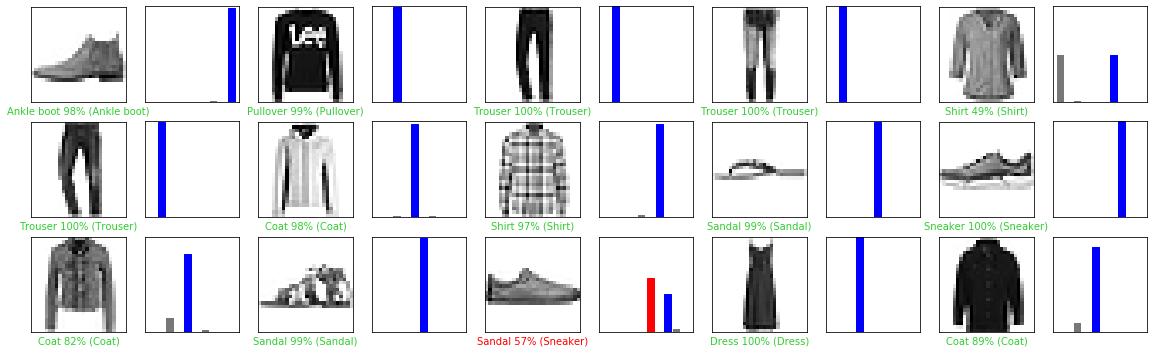

In [12]:
# 처음 num_rows x num_cols 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력해 봅니다.
# 올바른 예측은 녹색으로 잘못된 예측은 빨강색으로 표시합니다.
num_rows = 3
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

In [13]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]
print(img.shape)

# 입력 형태를 맞춰야 하기 때문에 (1, 28, 28)로 차원을 확장합니다.
img = (np.expand_dims(img,0))
print(img.shape)

predictions_single = model.predict(img)
print(f"pred prob: {predictions_single}")
print(f"pred class: {np.argmax(predictions_single[0])}")
print(f"read class: {test_labels[0]}")

(28, 28)
(1, 28, 28)
pred prob: [[0.00001 0.00000 0.00000 0.00000 0.00000 0.00319 0.00000 0.01791 0.00016
  0.97873]]
pred class: 9
read class: 9


In [14]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.